In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qanda-dataset/train.csv
/kaggle/input/qanda-dataset/test.csv


# **INSTALL GENSIM**

In [ ]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


# **IMPORT ALL THE LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import gensim
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.utils import simple_preprocess
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, confusion_matrix)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from nltk.corpus import stopwords
from sklearn.utils import resample
from transformers import (AutoTokenizer, TFAutoModelForSequenceClassification)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

2025-12-31 21:46:12.291086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767217572.770995      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767217572.889055      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767217573.989370      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767217573.989425      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767217573.989427      55 computation_placer.cc:177] computation placer alr

# **IMPORT THE TRAIN DATASET**

In [ ]:
df = pd.read_csv("/kaggle/input/qanda-dataset/train.csv", engine="python", on_bad_lines="skip")

# **FETCH FIRST 5 ROWS OF THE DATASET**

In [ ]:
df.head(5)

,QA Text,Class
0,"<html> Question Title:\n <br> What does ""el ch...",Society & Culture
1,<html> Question Title:\n <br> should inlaws be...,Family & Relationships
2,<html> Question Title:\n <br> Personals on my ...,Business & Finance
3,<html> Question Title:\n <br> How many African...,Politics & Government
4,<html> Question Title:\n <br> if you get burne...,Health


# **DATA PREPROCESSING FOR NLP TEXT**

In [ ]:
df.dropna(subset=['QA Text', 'Class'], inplace=True)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def nlp_clean(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = text.replace('\\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    cleaned_words = [w for w in words if w not in stop_words]
    return " ".join(cleaned_words)
df['QA Text'] = df['QA Text'].apply(nlp_clean)
df = df[df['QA Text'].str.strip() != ""]
print(f"Data remaining after cleaning: {len(df)} rows")
classes = df['Class'].value_counts()
max_count = classes.max()
df_list = []
for cls in classes.index:
    df_cls = df[df['Class'] == cls]
    if len(df_cls) < max_count:
        df_cls_over = resample(df_cls,
                               replace=True,
                               n_samples=max_count,
                               random_state=42)
        df_list.append(df_cls_over)
    else:
        df_list.append(df_cls)
df = pd.concat(df_list).sample(frac=1, random_state=42)
print(f"Data after balancing: {len(df)} rows")
print(df['Class'].value_counts())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data remaining after cleaning: 93333 rows
Data after balancing: 94190 rows
Class
Education & Reference     9419
Science & Mathematics     9419
Family & Relationships    9419
Sports                    9419
Society & Culture         9419
Computers & Internet      9419
Business & Finance        9419
Politics & Government     9419
Health                    9419
Entertainment & Music     9419
Name: count, dtype: int64


# **EDA 1.1: SUMMARY OF THE DATASET**

In [ ]:
temp = df.describe(include='all')
temp

,QA Text,Class
count,94190,94190
unique,62398,10
top,question title paralegal help question content...,Education & Reference
freq,6,9419


# **FETCH FIRST 10 ROWS OF THE CLEANED DATASET**

In [ ]:
df.head(10)

,QA Text,Class
87117,question title whats best bookontape learning ...,Education & Reference
32640,question title ash lowest state energy questio...,Science & Mathematics
57780,question title first second third base questio...,Family & Relationships
46715,question title year germany first world cup qu...,Sports
44813,question title curious website help talk way p...,Society & Culture
23346,question title valuable player award nba title...,Sports
12808,question title anyone else really love grammar...,Education & Reference
26989,question title population maori new zealand ye...,Education & Reference
59830,question title website design creation busines...,Computers & Internet
62206,question title exxon mobil retail stores going...,Business & Finance


# **EDA 1.2: DATA VISUALIZATION AND ANALYSIS**

/tmp/ipykernel_55/1435524462.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[1, 0])


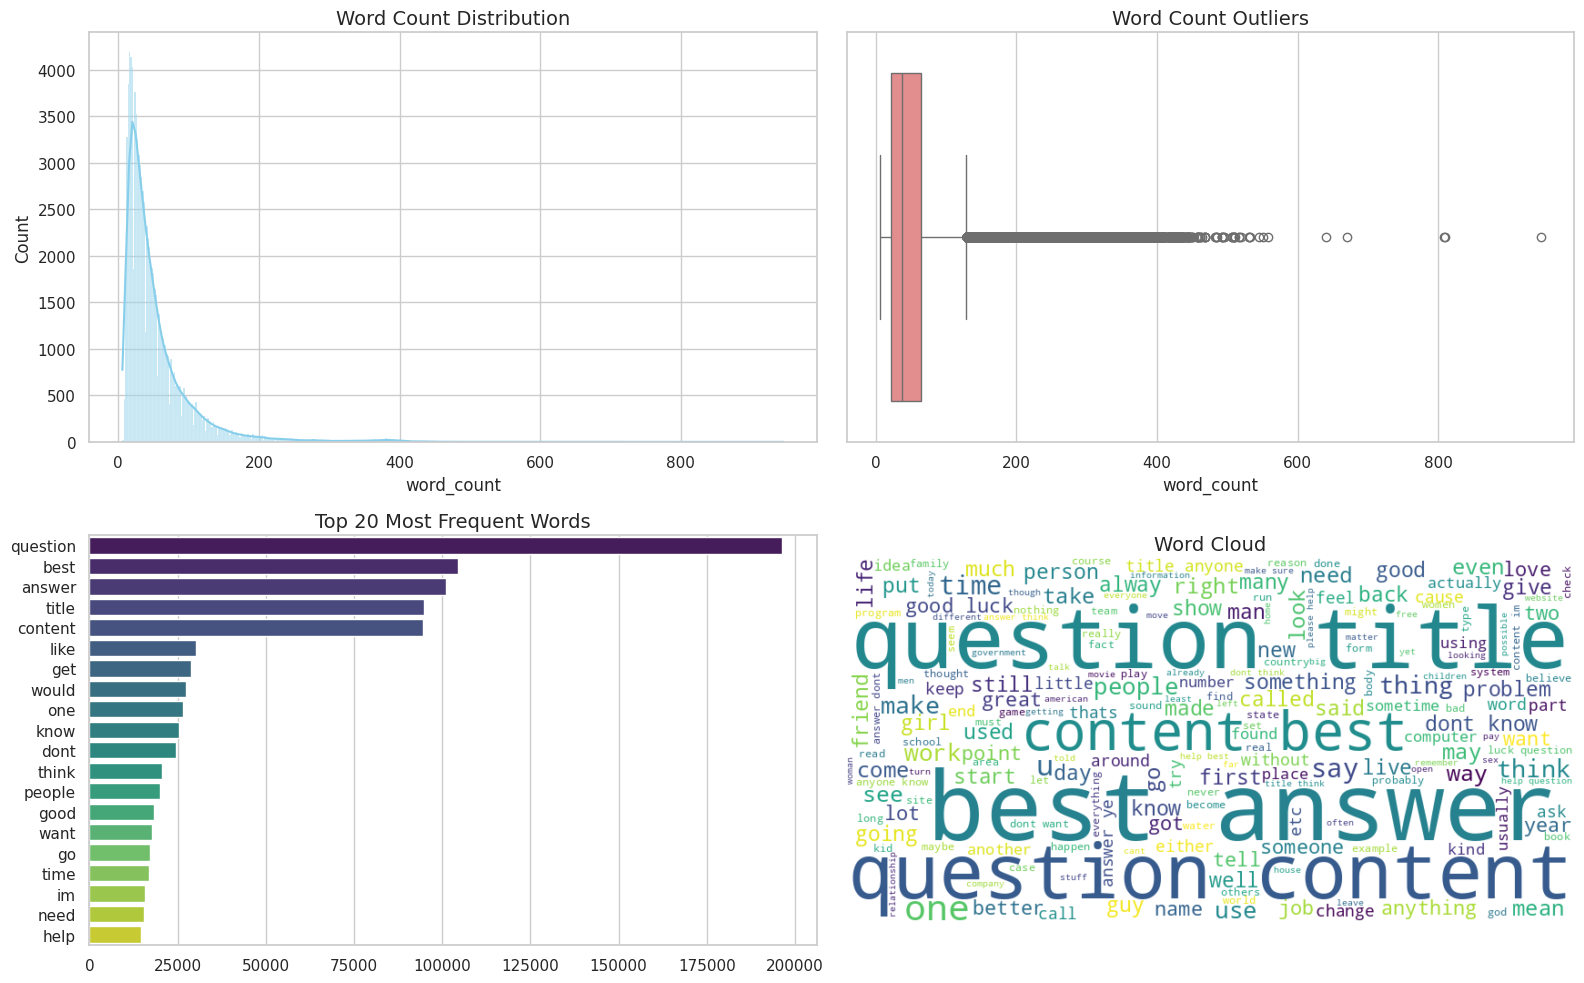

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
sns.set(style="whitegrid")
def perform_advanced_text_eda(df, column):
    df['char_count'] = df[column].apply(len)
    df['word_count'] = df[column].apply(lambda x: len(x.split()))
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    sns.histplot(df['word_count'], kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Word Count Distribution', fontsize=14)
    sns.boxplot(x=df['word_count'], ax=axes[0, 1], color='lightcoral')
    axes[0, 1].set_title('Word Count Outliers', fontsize=14)
    all_words = ' '.join(df[column]).split()
    word_freq = Counter(all_words).most_common(20)
    words, counts = zip(*word_freq)
    sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[1, 0])
    axes[1, 0].set_title("Top 20 Most Frequent Words", fontsize=14)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[column]))
    axes[1, 1].imshow(wordcloud, interpolation='bilinear')
    axes[1, 1].axis('off')
    axes[1, 1].set_title("Word Cloud", fontsize=14)
    plt.tight_layout()
    plt.show()
perform_advanced_text_eda(df, 'QA Text')
plt.show()

# **EDA 1.3: TOP 10 BIGRAM PLOTS**

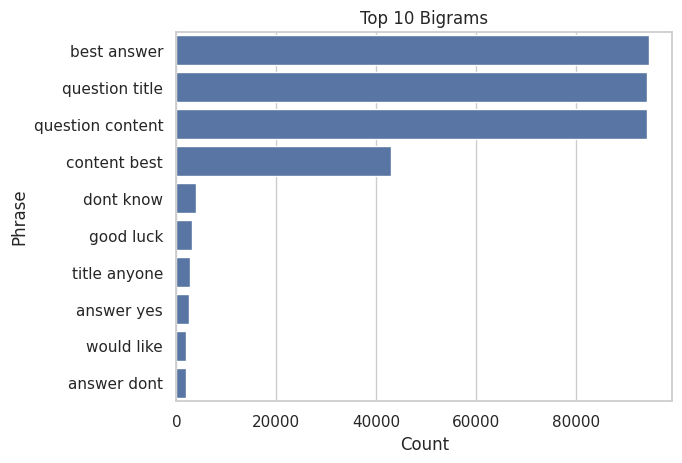

In [ ]:
def plot_ngrams(text_series, n=2, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text_series)
    bag_of_words = vec.transform(text_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    ngram_df = pd.DataFrame(words_freq[:top_k], columns=['Phrase', 'Count'])
    sns.barplot(x='Count', y='Phrase', data=ngram_df).set(title=f'Top {top_k} Bigrams')
    plt.show()
plot_ngrams(df['QA Text'], n=2)

# **EDA 1.4: SCATTER PLOT**

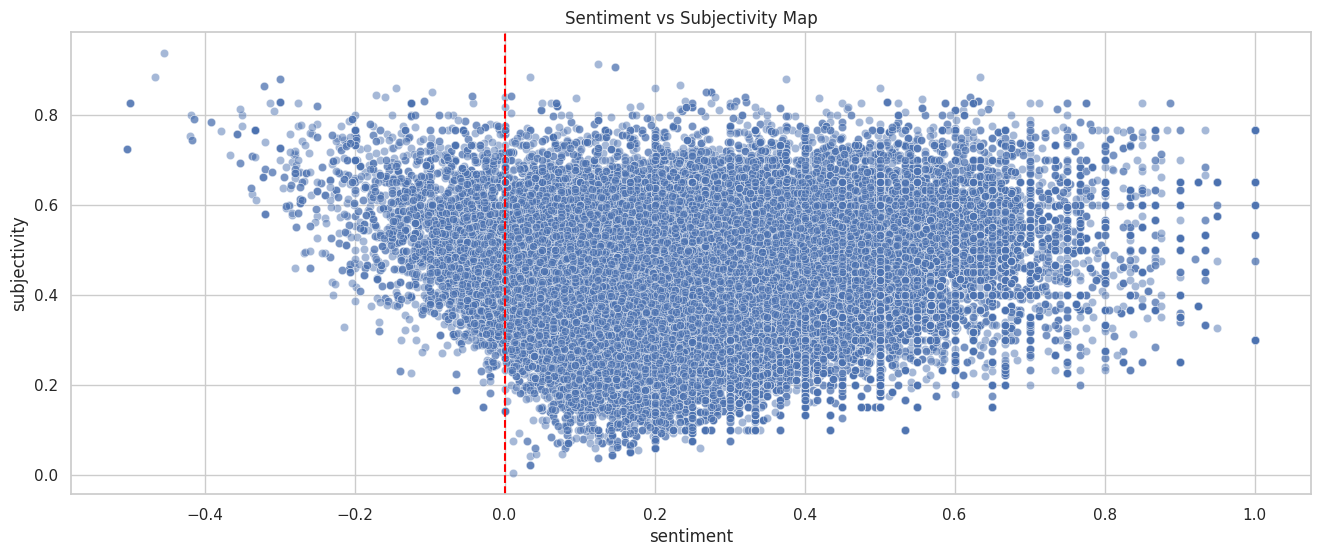

In [ ]:
from textblob import TextBlob
df['sentiment'] = df['QA Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['QA Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x='sentiment', y='subjectivity', alpha=0.5)
plt.title('Sentiment vs Subjectivity Map')
plt.axvline(0, color='red', linestyle='--')
plt.show()

In [ ]:
tfidf = TfidfVectorizer()
matrix = tfidf.fit_transform(df['QA Text'])
feature_names = tfidf.get_feature_names_out()
idf_scores = tfidf.idf_
idf_series = pd.Series(idf_scores, index=feature_names)
is_purely_numeric = idf_series.index.str.isdigit()
idf_series_filtered = idf_series[~is_purely_numeric]
idf_series_filtered.sort_values(ascending=False).head(10)

0068666moles                                        11.759933
한국전쟁                                                11.759933
0000000000is                                        11.759933
0000000500x833b75800x000000010xb1b2f850x00000000    11.759933
0065n                                               11.759933
00023gl                                             11.759933
00567g0025l                                         11.759933
000368mol                                           11.759933
00567g                                              11.759933
009677777moles                                      11.759933
dtype: float64

# **TRAIN AND VALIDATION SPLIT**

In [ ]:
X = df["QA Text"]
y = df["Class"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
tfidf = TfidfVectorizer(max_features=70000, ngram_range=(1,1), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf  = tfidf.transform(X_val)

# **APPLYING NAIVE BAYES CLASSIFIER**

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred = nb_model.predict(X_val_tfidf)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (Macro): {f1:.4f}")
print("\nClassification Report:")
print(class_report)

Accuracy: 0.7236
F1-score (Macro): 0.7199

Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.67      0.55      0.60      1884
  Computers & Internet       0.81      0.90      0.86      1883
 Education & Reference       0.70      0.47      0.57      1884
 Entertainment & Music       0.78      0.65      0.71      1884
Family & Relationships       0.56      0.89      0.69      1884
                Health       0.73      0.82      0.77      1884
 Politics & Government       0.75      0.82      0.78      1884
 Science & Mathematics       0.77      0.74      0.76      1884
     Society & Culture       0.66      0.60      0.63      1883
                Sports       0.89      0.80      0.84      1884

              accuracy                           0.72     18838
             macro avg       0.73      0.72      0.72     18838
          weighted avg       0.73      0.72      0.72     18838



# **CONFUSION MATRIX FOR TF-IDF NAIVE BAYES CLASSIFIER**

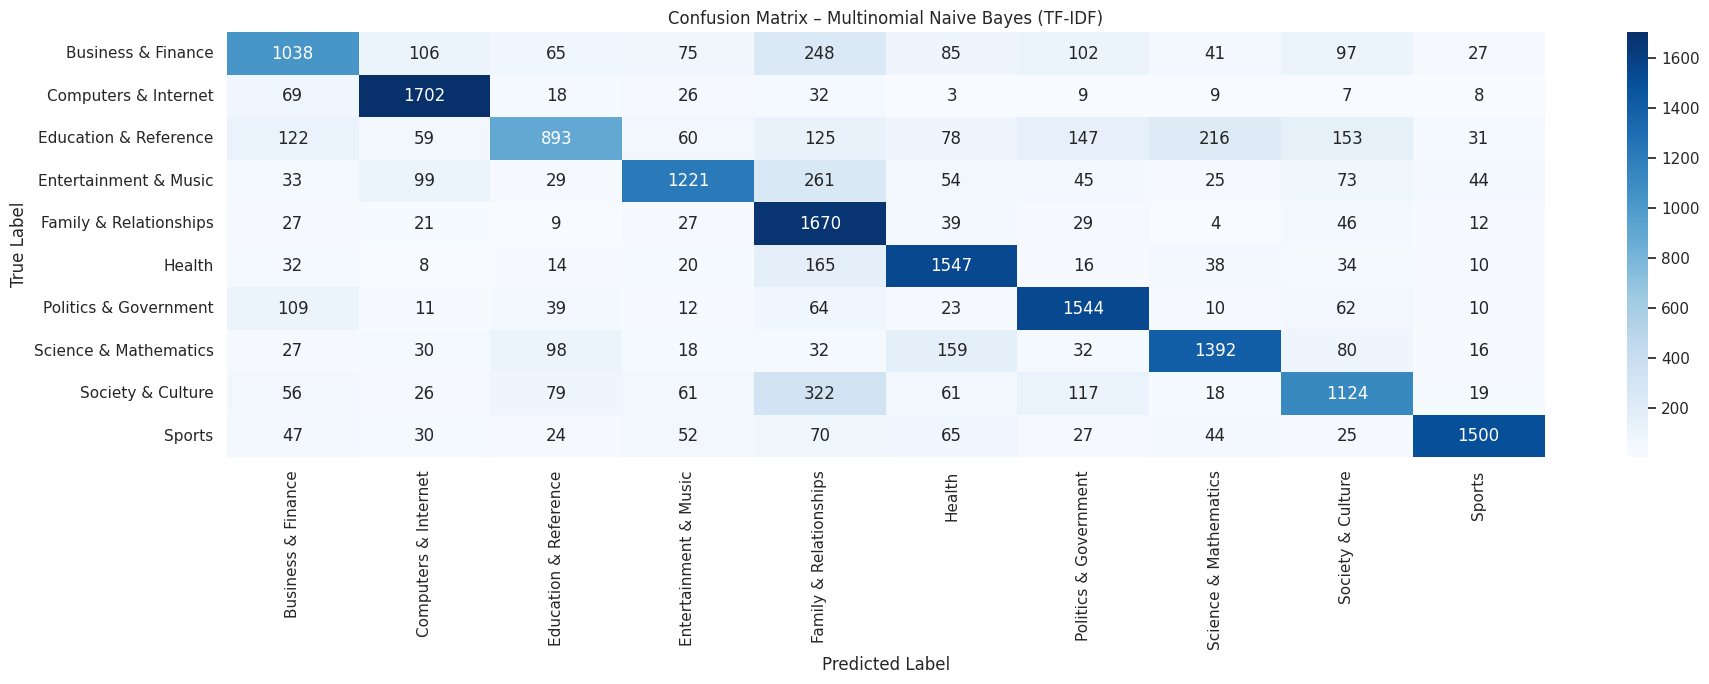

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
classes = sorted(y_val.unique())
plt.figure(figsize=(19, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Multinomial Naive Bayes (TF-IDF)")
plt.tight_layout()
plt.show()

# **APPLYING TF-IDF VECTORIZER WITH EARLY STOPPING**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_vec = tfidf.fit_transform(X)
X_vec = X_vec.astype('float32')
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)
X_train, X_val, y_train, y_val = train_test_split(X_vec, y_cat, test_size=0.2, random_state=42)
model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    X_train.toarray(),
    y_train,
    epochs=50,
    batch_size=42,
    validation_data=(X_val.toarray(), y_val),
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1767217763.664421      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767217763.668357      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1767217772.440801     132 service.cc:152] XLA service 0x7f8cd0005ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767217772.440840     132 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767217772.440845     132 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767217772.821028     132 cuda_dnn.cc:529] Loaded cuDNN version 91002


  69/1795 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1488 - loss: 2.2956

I0000 00:00:1767217774.822094     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1795/1795 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5376 - loss: 1.4467 - val_accuracy: 0.7171 - val_loss: 0.9065
Epoch 2/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7510 - loss: 0.8031 - val_accuracy: 0.7461 - val_loss: 0.8325
Epoch 3/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8126 - loss: 0.6126 - val_accuracy: 0.7677 - val_loss: 0.7978
Epoch 4/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8559 - loss: 0.4662 - val_accuracy: 0.7914 - val_loss: 0.7814
Epoch 5/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8877 - loss: 0.3622 - val_accuracy: 0.8049 - val_loss: 0.7918
Epoch 6/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9111 - loss: 0.2847 - val_accuracy: 0.8119 - val_loss: 0.8366
Epoch 7/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9270 - loss: 0.2290 - val_accuracy: 0.8183 - val_loss: 0.8745


# **TUNING HISTORY**

**For Batch Size 42**

Epoch 10/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9990 - loss: 0.0078 - val_accuracy: 0.6005 - val_loss: 2.2694

**For Batch Size 52**

Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9977 - loss: 0.0106 - val_accuracy: 0.6023 - val_loss: 2.1629

**For Batch size 52 with early stopping at epochs 7**

Epoch 7/50
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9270 - loss: 0.2290 - val_accuracy: 0.8183 - val_loss: 0.8745

# **APPLYING WORD TO VECTOR ~SKIP GRAM**

In [ ]:
sentences = df["QA Text"].apply(lambda x: simple_preprocess(str(x))).tolist()
w2v = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    workers=4,
    epochs=10
)
word_index = {word: i + 1 for i, word in enumerate(w2v.wv.index_to_key)}
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = w2v.wv[word]
MAX_LEN = 200
def encode_sentence(sentence):
    return [word_index[word] for word in sentence if word in word_index]
X_seq = pad_sequences(
    [encode_sentence(s) for s in sentences],
    maxlen=MAX_LEN,
    padding="post"
)
le = LabelEncoder()
y_enc = le.fit_transform(df["Class"])
X_train, X_val, y_train_enc, y_val_enc = train_test_split(
    X_seq,
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)
y_train = to_categorical(y_train_enc)
y_val = to_categorical(y_val_enc)

# **TRAIN A DEEP NEURAL NETWORK**

In [ ]:
num_classes = y_train.shape[1]
dnn_model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    Conv1D(128, kernel_size=5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
dnn_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
dnn_model.fit(
    X_train,
    y_train,
    epochs=6,
    batch_size=42,
    validation_split=0.1
)

Epoch 1/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.5199 - loss: 1.4575 - val_accuracy: 0.7216 - val_loss: 0.8848
Epoch 2/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7458 - loss: 0.8398 - val_accuracy: 0.7719 - val_loss: 0.7677
Epoch 3/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8312 - loss: 0.5708 - val_accuracy: 0.7939 - val_loss: 0.7141
Epoch 4/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8982 - loss: 0.3423 - val_accuracy: 0.8126 - val_loss: 0.7440
Epoch 5/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9400 - loss: 0.2080 - val_accuracy: 0.8202 - val_loss: 0.8650
Epoch 6/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9627 - loss: 0.1269 - val_accuracy: 0.8207 - val_loss: 1.0430


# **TUNING HISTORY**

**For epochs=10, batch_size=32, validation_split=0.1**

Epoch 10/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7940 - loss: 0.6340 - val_accuracy: 0.6248 - val_loss: 1.3480

**For epochs=15, batch_size=32, validation_split=0.1**

Epoch 15/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8981 - loss: 0.3210 - val_accuracy: 0.6023 - val_loss: 1.6255

**For epochs=35, batch_size=42, validation_split=0.1**

Epoch 35/35
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9668 - loss: 0.1085 - val_accuracy: 0.5867 - val_loss: 2.9696

**For epochs=6, batch_size=42, validation_split=0.1**

Epoch 6/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9627 - loss: 0.1269 - val_accuracy: 0.8207 - val_loss: 1.0430

# **TRAIN A RNN MODEL**

In [ ]:
num_classes = y_train.shape[1]
rnn_model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    SimpleRNN(128),
    Dense(num_classes, activation="softmax")
])
rnn_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
rnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=42,
    validation_split=0.1
)

Epoch 1/10
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.1008 - loss: 2.3260 - val_accuracy: 0.0983 - val_loss: 2.3207
Epoch 2/10
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.1025 - loss: 2.3156 - val_accuracy: 0.1034 - val_loss: 2.3103
Epoch 3/10
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.1082 - loss: 2.3112 - val_accuracy: 0.1210 - val_loss: 2.3120
Epoch 4/10
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.1198 - loss: 2.3024 - val_accuracy: 0.1003 - val_loss: 2.3120
Epoch 5/10
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.1092 - loss: 2.3091 - val_accuracy: 0.1209 - val_loss: 2.3092
Epoch 6/10
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.1137 - loss: 2.3011 - val_accuracy: 0.1002 - val_loss: 2.3029
Epoch 7/10
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.1107 - loss: 2.2974 - val_accuracy: 0.1067 - val_loss: 2.3178
Epoch 8/10
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.1116 -

# **TUNING HISTORY**

**For epochs=20, batch_size=32**

Epoch 20/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2001 - loss: 2.1498

**For epochs=20, batch_size=42**

Epoch 20/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2696 - loss: 2.0159

**For epochs=10, batch_size=42**

Epoch 10/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4187 - loss: 1.6839

**For epochs=10 batch_size=42, validation_split=0.1**

Epoch 10/10
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.1202 - loss: 2.2745 - val_accuracy: 0.1050 - val_loss: 2.2964

**TRAIN A LSTM MODEL**

In [ ]:
num_classes = y_train.shape[1]
lstm_model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    LSTM(128),
    Dense(num_classes, activation="softmax")
])
lstm_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
lstm_model.fit(
    X_train,
    y_train,
    epochs=6,
    batch_size=42,
    validation_split=0.1
)

Epoch 1/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.1072 - loss: 2.2927 - val_accuracy: 0.1081 - val_loss: 2.2937
Epoch 2/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.1135 - loss: 2.2800 - val_accuracy: 0.3700 - val_loss: 1.8008
Epoch 3/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.4613 - loss: 1.5497 - val_accuracy: 0.6753 - val_loss: 1.0670
Epoch 4/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7362 - loss: 0.8801 - val_accuracy: 0.7395 - val_loss: 0.8674
Epoch 5/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8277 - loss: 0.5984 - val_accuracy: 0.7748 - val_loss: 0.7751
Epoch 6/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8875 - loss: 0.3948 - val_accuracy: 0.7938 - val_loss: 0.7545


# **TUNING HISTORY**

**For epochs=20, batch_size=32**

Epoch 20/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7463 - loss: 0.7775

**For epochs=30, batch_size=42**

Epoch 30/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8195 - loss: 0.5521

**For epochs=40, batch_size=42**

Epoch 40/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8766 - loss: 0.3888

**For epochs=6, batch_size=42, validation_split=0.1**

Epoch 6/6
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8875 - loss: 0.3948 - val_accuracy: 0.7938 - val_loss: 0.7545

# **TRAIN A GRU MODEL**

In [ ]:
num_classes = y_train.shape[1]
gru_model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    GRU(128),
    Dense(num_classes, activation="softmax")
])
gru_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
gru_model.fit(
    X_train,
    y_train,
    epochs=4,
    batch_size=42,
    validation_split=0.1
)

Epoch 1/4
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.1072 - loss: 2.2937 - val_accuracy: 0.5487 - val_loss: 1.4007
Epoch 2/4
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.6789 - loss: 1.0312 - val_accuracy: 0.7432 - val_loss: 0.8140
Epoch 3/4
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.8134 - loss: 0.6048 - val_accuracy: 0.7889 - val_loss: 0.7041
Epoch 4/4
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9022 - loss: 0.3302 - val_accuracy: 0.8060 - val_loss: 0.7060


# **TUNING HISTORY**

**For epochs=30, batch_size=32**

Epoch 20/20
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8185 - loss: 0.5527

**For epochs=30, batch_size=42**

Epoch 30/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9181 - loss: 0.2651

**For epochs=4, batch_size=42, validation_split=0.1**

Epoch 4/4
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9022 - loss: 0.3302 - val_accuracy: 0.8060 - val_loss: 0.7060

# **TRAIN A BI-DIRECTIONAL RNN**

In [ ]:
num_classes = y_train.shape[1]
bi_rnn = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    Bidirectional(SimpleRNN(128)),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
bi_rnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
bi_rnn.fit(
    X_train,
    y_train,
    epochs=4,
    batch_size=52,
    validation_split=0.1
)

Epoch 1/4
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.4162 - loss: 1.7123 - val_accuracy: 0.6689 - val_loss: 1.0801
Epoch 2/4
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.6832 - loss: 1.0661 - val_accuracy: 0.6973 - val_loss: 0.9855
Epoch 3/4
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.7535 - loss: 0.8657 - val_accuracy: 0.7302 - val_loss: 0.9063
Epoch 4/4
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.7912 - loss: 0.7324 - val_accuracy: 0.7217 - val_loss: 0.9645


# **TUNING HISTORY**

**For epochs=25, batch_size=32, validation_split=0.1**

Epoch 25/25
325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6812 - loss: 0.9449 - val_accuracy: 0.5815 - val_loss: 1.4941

**For epochs=25, batch_size=52, validation_split=0.1**

Epoch 25/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7401 - loss: 0.7816 - val_accuracy: 0.5633 - val_loss: 1.5644

**For epochs=25, batch_size=66, validation_split=0.1**

Epoch 25/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7200 - loss: 0.8289 - val_accuracy: 0.5858 - val_loss: 1.5533

**For epochs=4, batch_size=52, validation_split=0.1**

Epoch 4/4
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.7912 - loss: 0.7324 - val_accuracy: 0.7217 - val_loss: 0.9645

# **TRAIN A BI-DIRECTIONAL GRU**

In [ ]:
num_classes = y_train.shape[1]
bi_gru = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    Bidirectional(GRU(128)),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
bi_gru.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
bi_gru.fit(
    X_train,
    y_train,
    epochs=3,
    batch_size=42,
    validation_split=0.1
)

Epoch 1/3
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.5470 - loss: 1.3836 - val_accuracy: 0.7183 - val_loss: 0.8844
Epoch 2/3
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.7701 - loss: 0.7838 - val_accuracy: 0.7699 - val_loss: 0.7726
Epoch 3/3
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.8578 - loss: 0.5035 - val_accuracy: 0.7992 - val_loss: 0.7457


# **TUNING HISTORY**

**For epochs=20, batch_size=32, validation_split=0.1**

Epoch 20/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8370 - loss: 0.4907 - val_accuracy: 0.6326 - val_loss: 1.6461

**For epochs=30, batch_size=42, validation_split=0.1**

Epoch 30/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9176 - loss: 0.2389 - val_accuracy: 0.5927 - val_loss: 2.3874

**For epochs=40, batch_size=42, validation_split=0.1**

Epoch 40/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9640 - loss: 0.1110 - val_accuracy: 0.5901 - val_loss: 3.3081

**For epochs=3, batch_size=52, validation_split=0.1**

Epoch 3/3
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.8578 - loss: 0.5035 - val_accuracy: 0.7992 - val_loss: 0.7457

# **TRAIN A BI-DIRECTIONAL LSTM**

In [ ]:
num_classes = y_train.shape[1]
bi_lstm = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    Bidirectional(LSTM(128)),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
bi_lstm.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
bi_lstm.fit(
    X_train,
    y_train,
    epochs=3,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/3
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.5755 - loss: 1.3387 - val_accuracy: 0.7337 - val_loss: 0.8639
Epoch 2/3
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.7677 - loss: 0.7955 - val_accuracy: 0.7631 - val_loss: 0.7899
Epoch 3/3
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.8458 - loss: 0.5449 - val_accuracy: 0.7938 - val_loss: 0.7272


# **TUNING HISTORY**

**For epochs=10, batch_size=32, validation_split=0.1**

Epoch 10/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6833 - loss: 1.0084 - val_accuracy: 0.6534 - val_loss: 1.1033

**For epochs=20, batch_size=32, validation_split=0.1**

Epoch 20/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8241 - loss: 0.5239 - val_accuracy: 0.6213 - val_loss: 1.5772

**For epochs=30, batch_size=32, validation_split=0.1**

Epoch 30/30
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9243 - loss: 0.2284 - val_accuracy: 0.5919 - val_loss: 2.5473

**For epochs=40, batch_size=32, validation_split=0.1**

Epoch 40/40
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9677 - loss: 0.1059 - val_accuracy: 0.5953 - val_loss: 3.1509

**For epochs=3, batch_size=32, validation_split=0.1**

Epoch 3/3
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.8458 - loss: 0.5449 - val_accuracy: 0.7938 - val_loss: 0.7272

# **COUNTING UNIQUE CATEGORIES IN THE CLASS COLUMN**

In [ ]:
num_labels = df['Class'].nunique()
print(num_labels)

10


# **EVAL 1.1: CONFUSION MATRIX VISUALIZATION**

In [ ]:
def get_predictions(model, X_val):
    y_prob = model.predict(X_val)
    y_pred = np.argmax(y_prob, axis=1)
    return y_pred
def print_classification_report(model, X_val, y_val, label_encoder):
    y_pred = get_predictions(model, X_val)
    y_true = np.argmax(y_val, axis=1)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("\nClassification Report:\n", report)
    return acc, f1, report
def plot_confusion_matrix(model, X_val, y_val, label_encoder, COLOR):
    expected_dim = model.input_shape[-1]
    if X_val.ndim == 2 and X_val.shape[1] != expected_dim:
        X_val = np.pad(
            X_val,
            ((0, 0), (0, max(0, expected_dim - X_val.shape[1]))),
            mode="constant"
        )[:, :expected_dim]
    y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(19, 7))
    sns.heatmap(cm,annot=True,fmt="d",cmap=COLOR,xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
def plot_confusion_matrices(models, model_names, X_val, y_val, label_encoder, cmap="Blues"):
    n = len(models)
    y_true = np.argmax(y_val, axis=1)
    fig, axes = plt.subplots(1, n, figsize=(9*n,7))
    if n == 1:
        axes = [axes]
    for i, model in enumerate(models):
        y_pred = np.argmax(model.predict(X_val), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", ax=axes[i],
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_,
                    cmap=cmap)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
        axes[i].set_title(model_names[i])
    plt.tight_layout()
    plt.show()

# **EVAL 1.2: AUC ROC CURVE VISUALIZATION**

In [ ]:
def create_roc_auc_curve(models, model_names, X_val, y_val, le=None):
    if le is not None:
        y_true = label_binarize(y_val, classes=le.classes_)[:, 0]
    else:
        y_true = y_val
    n_models = len(models)
    plt.figure(figsize=(18, 6))
    for i, (model, name) in enumerate(zip(models, model_names), 1):
        y_pred_prob = model.predict(X_val)
        if y_pred_prob.ndim > 1:
            y_pred_prob = y_pred_prob[:, 0]
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.subplot(1, n_models, i)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(name)
        plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [ ]:
def report_to_df(y_true, y_pred, label_encoder):
    report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    return df.round(2)

In [ ]:
y_true = np.argmax(y_val, axis=1)
y_pred1 = np.argmax(bi_lstm.predict(X_val), axis=1)
df1 = report_to_df(y_true, y_pred1, le)
y_pred2 = np.argmax(lstm_model.predict(X_val), axis=1)
df2 = report_to_df(y_true, y_pred2, le)

589/589 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


# **CREATING REPORTS**

In [ ]:
def display_side_by_side(dfs, captions):
    html_str = ""
    for df, cap in zip(dfs, captions):
        html_str += f"<div style='display:inline-block; vertical-align:top; margin-right:290px;'>"
        html_str += f"<h3>{cap}</h3>"
        html_str += df.to_html()
        html_str += "</div>"
    display(HTML(html_str))
display_side_by_side([df1, df2], ["REPORT OF BI-DIRECTIONAL LSTM", "REPORT UNI-DIRECTIONAL LSTM"])

,precision,recall,f1-score,support
Business & Finance,0.66,0.65,0.66,1884.0
Computers & Internet,0.90,0.92,0.91,1883.0
Education & Reference,0.80,0.57,0.66,1884.0
Entertainment & Music,0.79,0.79,0.79,1884.0
Family & Relationships,0.77,0.84,0.81,1884.0
Health,0.81,0.87,0.84,1884.0
Politics & Government,0.84,0.86,0.85,1884.0
Science & Mathematics,0.77,0.84,0.80,1884.0
Society & Culture,0.72,0.73,0.72,1883.0
Sports,0.89,0.88,0.89,1884.0


589/589 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


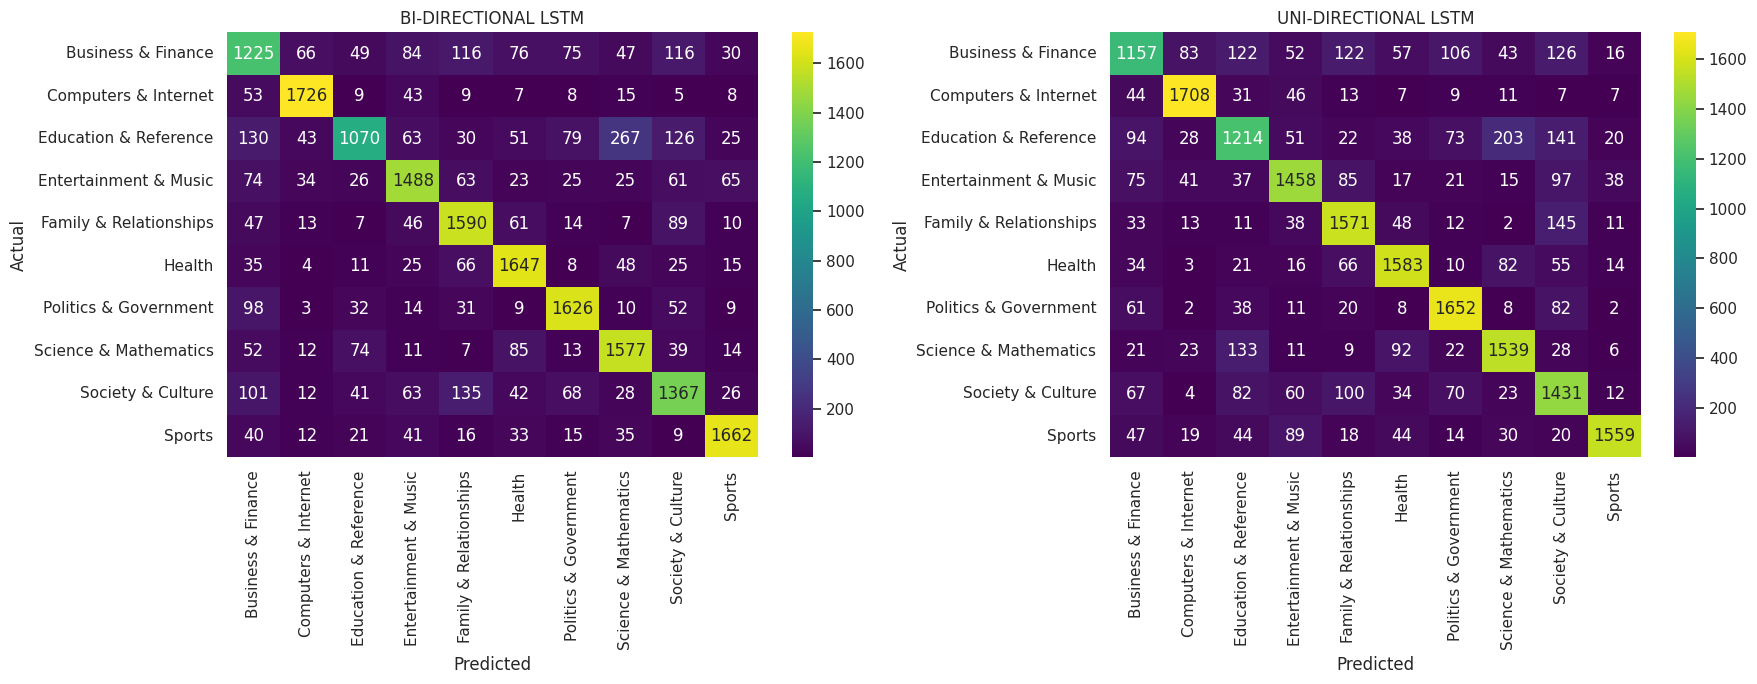

In [ ]:
plot_confusion_matrices(models=[bi_lstm, lstm_model], model_names=["BI-DIRECTIONAL LSTM", "UNI-DIRECTIONAL LSTM"], X_val=X_val, y_val=y_val, label_encoder=le, cmap="viridis")

589/589 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


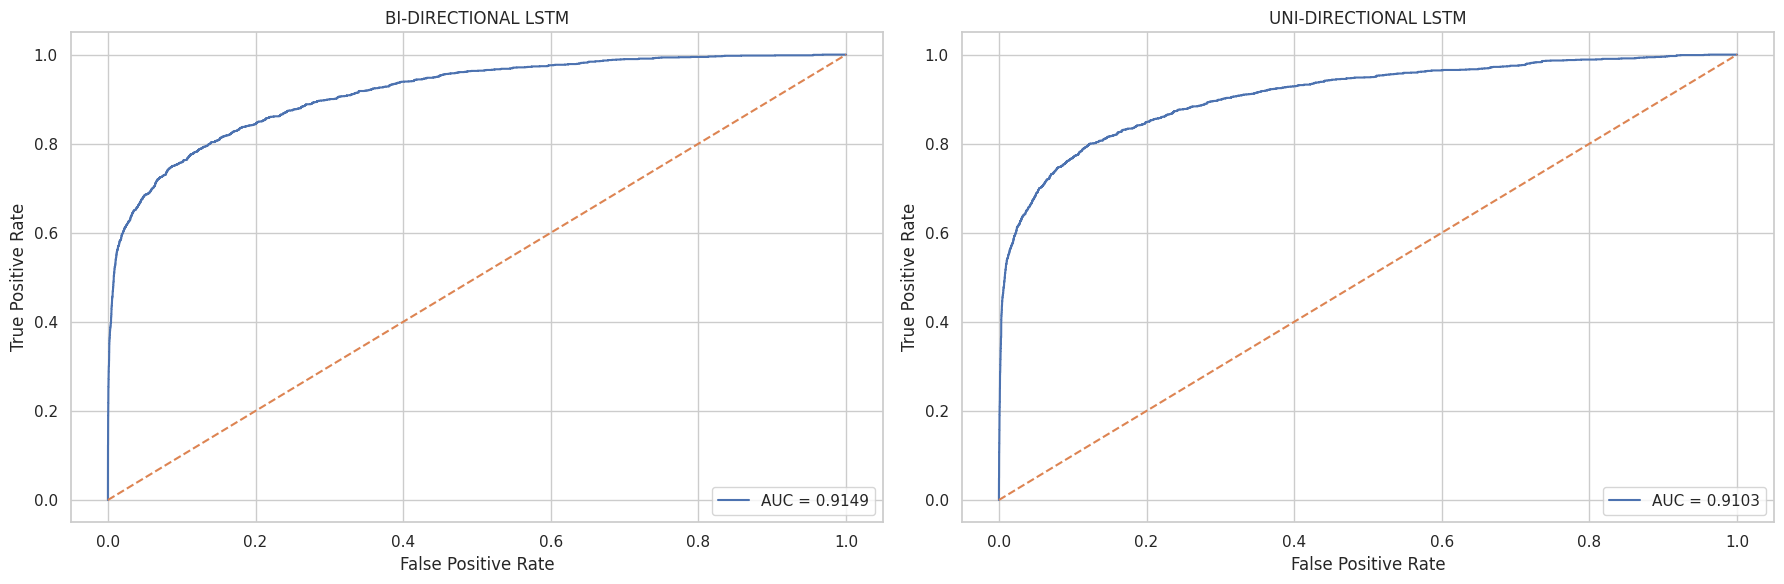

In [ ]:
create_roc_auc_curve([bi_lstm, lstm_model], ["BI-DIRECTIONAL LSTM", "UNI-DIRECTIONAL LSTM"], X_val, y_val, le)

In [ ]:
y_true = np.argmax(y_val, axis=1)
y_pred1 = np.argmax(bi_rnn.predict(X_val), axis=1)
df1 = report_to_df(y_true, y_pred1, le)
y_pred2 = np.argmax(rnn_model.predict(X_val), axis=1)
df2 = report_to_df(y_true, y_pred2, le)

589/589 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [ ]:
def display_side_by_side(dfs, captions):
    html_str = ""
    for df, cap in zip(dfs, captions):
        html_str += f"<div style='display:inline-block; vertical-align:top; margin-right:290px;'>"
        html_str += f"<h3>{cap}</h3>"
        html_str += df.to_html()
        html_str += "</div>"
    display(HTML(html_str))
display_side_by_side([df1, df2], ["REPORT OF BI-DIRECTIONAL RNN", "REPORT UNI-DIRECTIONAL RNN"])

,precision,recall,f1-score,support
Business & Finance,0.58,0.54,0.56,1884.00
Computers & Internet,0.73,0.92,0.81,1883.00
Education & Reference,0.60,0.57,0.58,1884.00
Entertainment & Music,0.70,0.77,0.73,1884.00
Family & Relationships,0.79,0.68,0.73,1884.00
Health,0.85,0.78,0.81,1884.00
Politics & Government,0.72,0.85,0.78,1884.00
Science & Mathematics,0.73,0.80,0.76,1884.00
Society & Culture,0.72,0.58,0.64,1883.00
Sports,0.90,0.80,0.85,1884.00


589/589 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


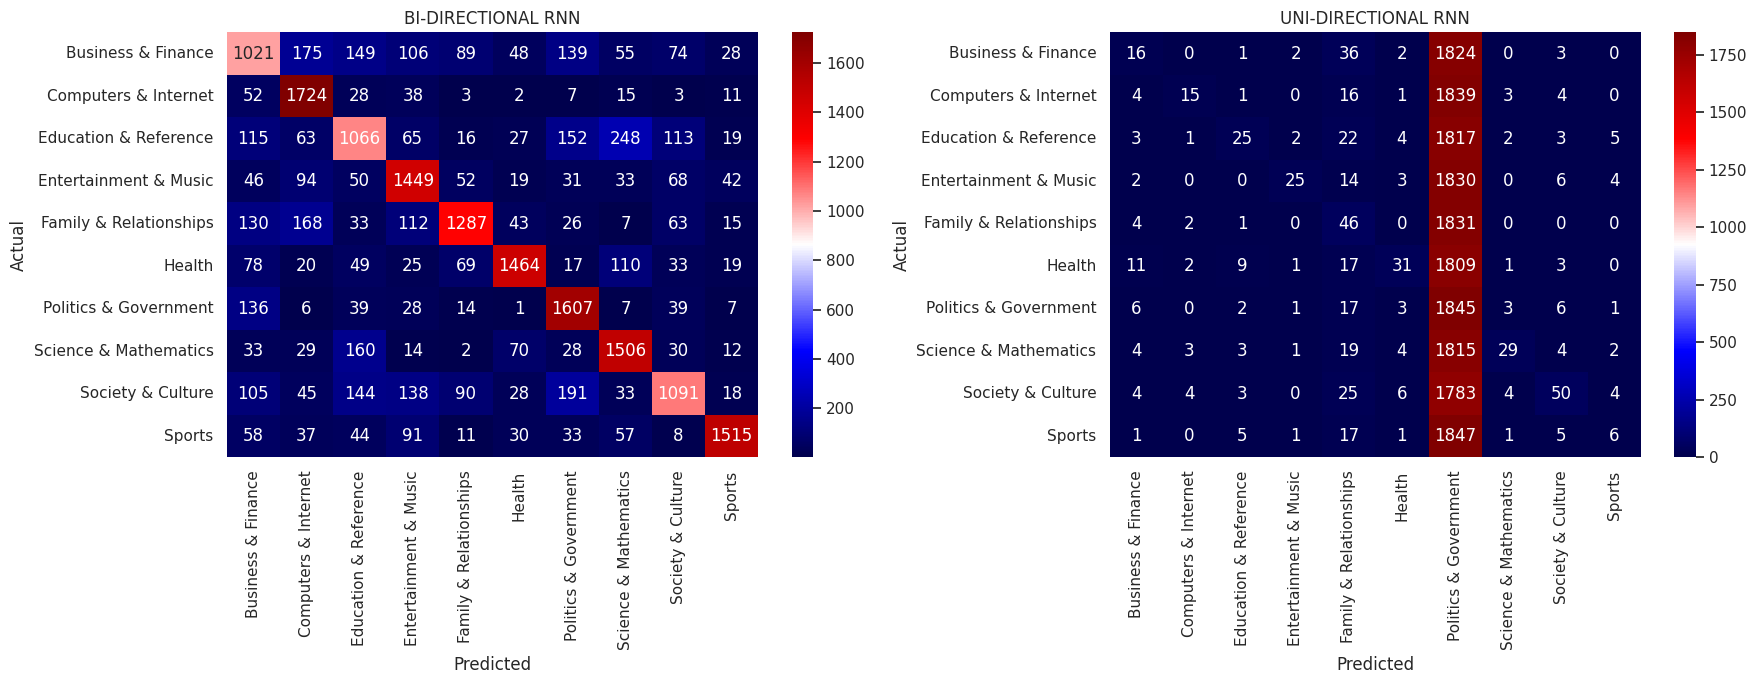

In [ ]:
plot_confusion_matrices(models=[bi_rnn, rnn_model], model_names=["BI-DIRECTIONAL RNN", "UNI-DIRECTIONAL RNN"], X_val=X_val, y_val=y_val, label_encoder=le, cmap="seismic")

589/589 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


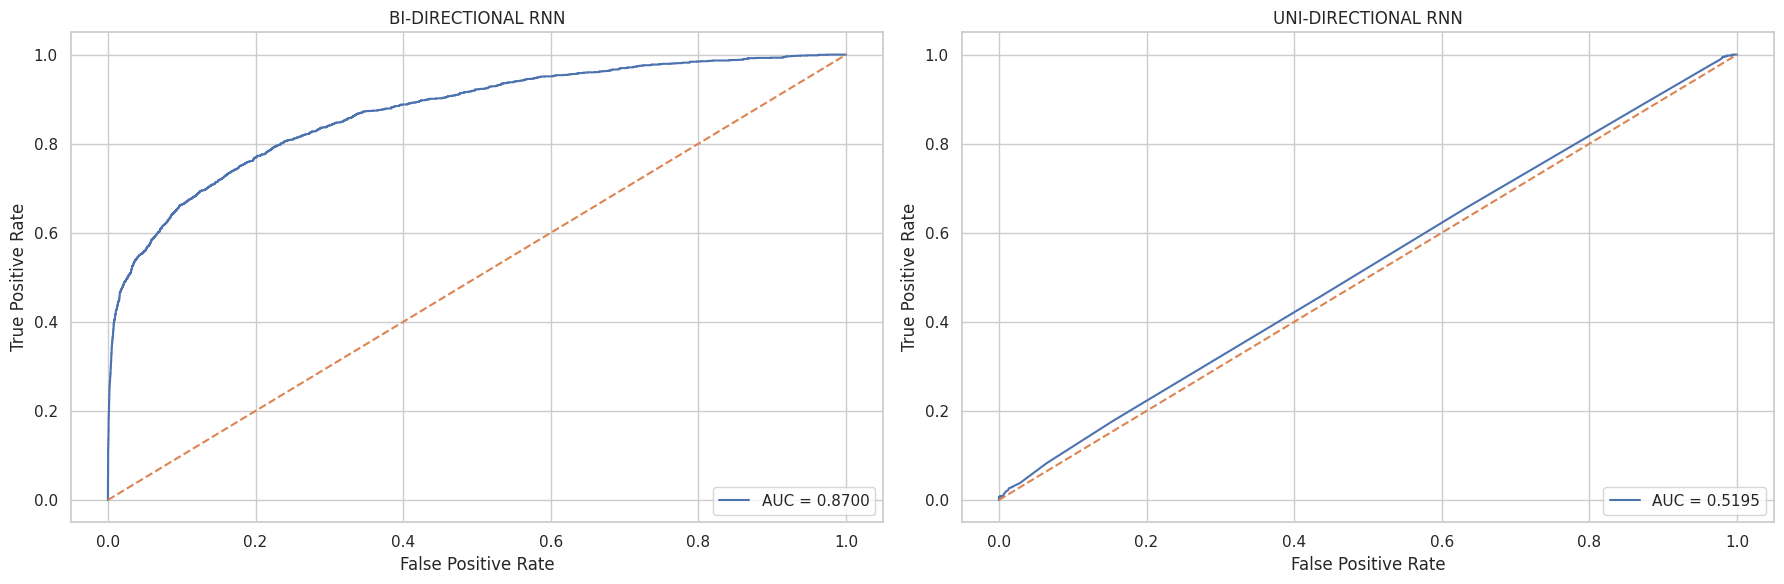

In [ ]:
create_roc_auc_curve([bi_rnn, rnn_model], ["BI-DIRECTIONAL RNN", "UNI-DIRECTIONAL RNN"], X_val, y_val, le)

In [ ]:
y_true = np.argmax(y_val, axis=1)
y_pred1 = np.argmax(bi_gru.predict(X_val), axis=1)
df1 = report_to_df(y_true, y_pred1, le)
y_pred2 = np.argmax(gru_model.predict(X_val), axis=1)
df2 = report_to_df(y_true, y_pred2, le)

589/589 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [ ]:
def display_side_by_side(dfs, captions):
    html_str = ""
    for df, cap in zip(dfs, captions):
        html_str += f"<div style='display:inline-block; vertical-align:top; margin-right:290px;'>"
        html_str += f"<h3>{cap}</h3>"
        html_str += df.to_html()
        html_str += "</div>"
    display(HTML(html_str))
display_side_by_side([df1, df2], ["REPORT OF BI-DIRECTIONAL GRU", "REPORT UNI-DIRECTIONAL GRU"])

,precision,recall,f1-score,support
Business & Finance,0.75,0.63,0.68,1884.0
Computers & Internet,0.89,0.92,0.91,1883.0
Education & Reference,0.67,0.68,0.68,1884.0
Entertainment & Music,0.77,0.79,0.78,1884.0
Family & Relationships,0.85,0.76,0.81,1884.0
Health,0.83,0.87,0.85,1884.0
Politics & Government,0.88,0.84,0.86,1884.0
Science & Mathematics,0.81,0.81,0.81,1884.0
Society & Culture,0.66,0.79,0.72,1883.0
Sports,0.89,0.87,0.88,1884.0


589/589 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


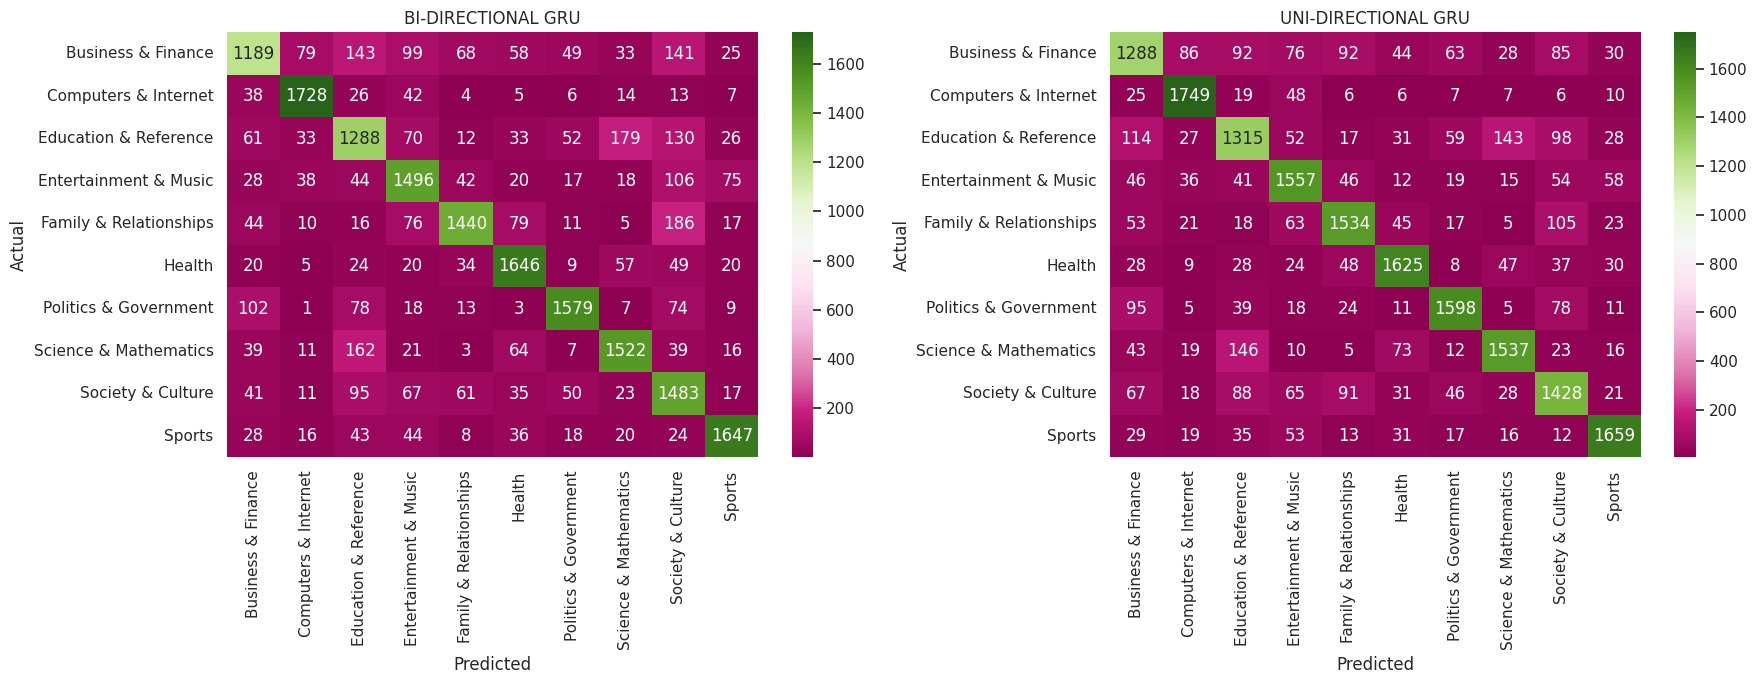

In [ ]:
plot_confusion_matrices(models=[bi_gru, gru_model], model_names=["BI-DIRECTIONAL GRU", "UNI-DIRECTIONAL GRU"], X_val=X_val, y_val=y_val, label_encoder=le, cmap="PiYG")

589/589 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


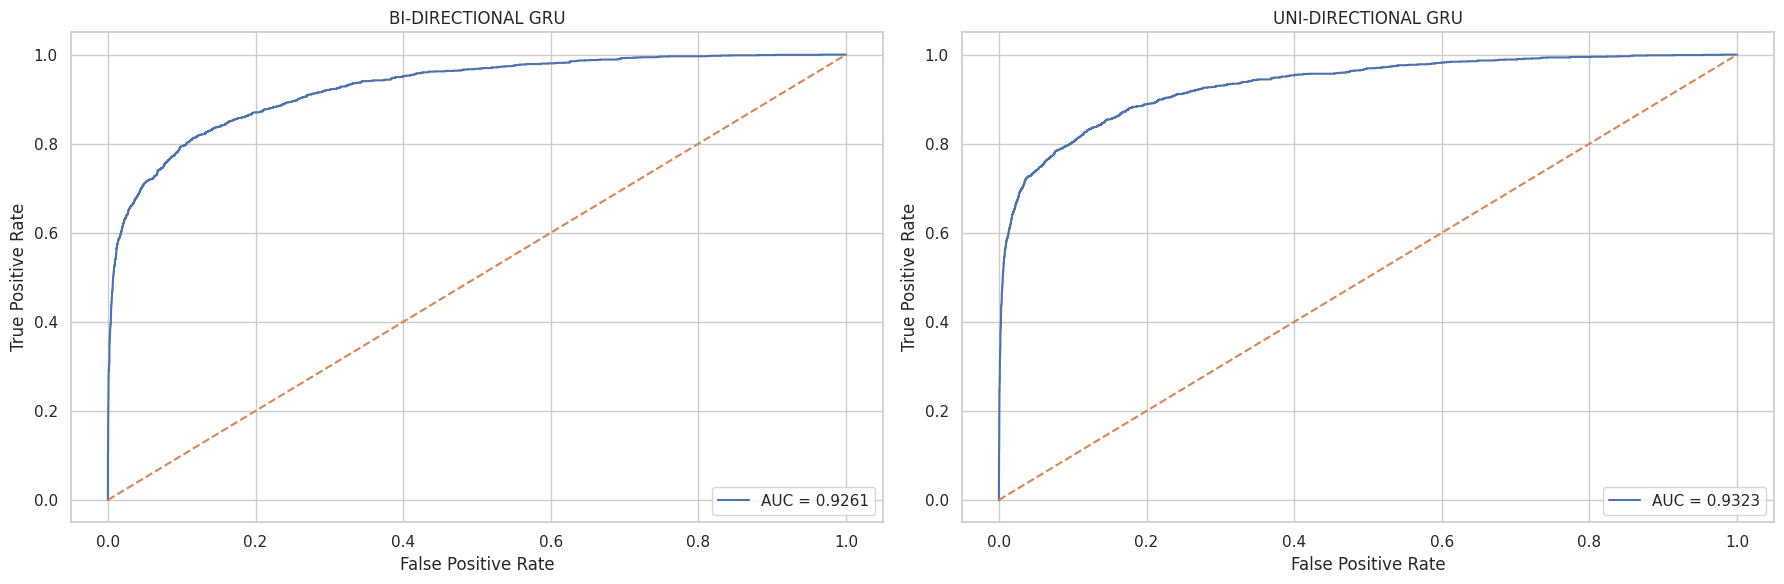

In [ ]:
create_roc_auc_curve([bi_gru, gru_model], ["BI-DIRECTIONAL GRU", "UNI-DIRECTIONAL GRU"], X_val, y_val, le)

In [ ]:
input_dim = X_train_tfidf.shape[1]
print(f"New input dimension: {input_dim}")

New input dimension: 70000


In [ ]:
tfidf_vec = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf_total = tfidf_vec.fit_transform(df['QA Text']).toarray()
y_tfidf_total = to_categorical(le.transform(df['Class']))
_, X_val_tfidf, _, y_val_tfidf = train_test_split(X_tfidf_total, y_tfidf_total, test_size=0.2, random_state=42)
y_pred_dnn = np.argmax(dnn_model.predict(X_val), axis=1)
y_true_dnn = np.argmax(y_val, axis=1)
y_pred_tfidf = np.argmax(model.predict(X_val_tfidf), axis=1)
y_true_tfidf = np.argmax(y_val_tfidf, axis=1)
report_dnn_dict = classification_report(y_true_dnn, y_pred_dnn, target_names=le.classes_, output_dict=True)
df_dnn = pd.DataFrame(report_dnn_dict).transpose()
report_tfidf_dict = classification_report(y_true_tfidf, y_pred_tfidf, target_names=le.classes_, output_dict=True)
df_tfidf = pd.DataFrame(report_tfidf_dict).transpose()
def display_side_by_side(dfs, captions):
    html_str = ""
    for df, cap in zip(dfs, captions):
        html_str += f"<div style='display:inline-block; vertical-align:top; margin-right:290px;'>"
        html_str += f"<h3 style='text-align:center;'>{cap}</h3>"
        html_str += df.to_html()
        html_str += "</div>"
    display(HTML(html_str))
display_side_by_side([df_dnn, df_tfidf], ["DEEP NEURAL NETWORK FOR SKIP GRAM", "DEEP NEURAL NETWORK FOR TF-IDF"])

589/589 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,precision,recall,f1-score,support
Business & Finance,0.713550,0.735138,0.724183,1884.000000
Computers & Internet,0.909139,0.908656,0.908898,1883.000000
Education & Reference,0.653394,0.766454,0.705423,1884.000000
Entertainment & Music,0.851576,0.788747,0.818958,1884.000000
Family & Relationships,0.814155,0.848726,0.831081,1884.000000
Health,0.856676,0.834395,0.845389,1884.000000
Politics & Government,0.860021,0.860934,0.860477,1884.000000
Science & Mathematics,0.827605,0.817941,0.822744,1884.000000
Society & Culture,0.804035,0.740839,0.771144,1883.000000
Sports,0.898763,0.848195,0.872747,1884.000000


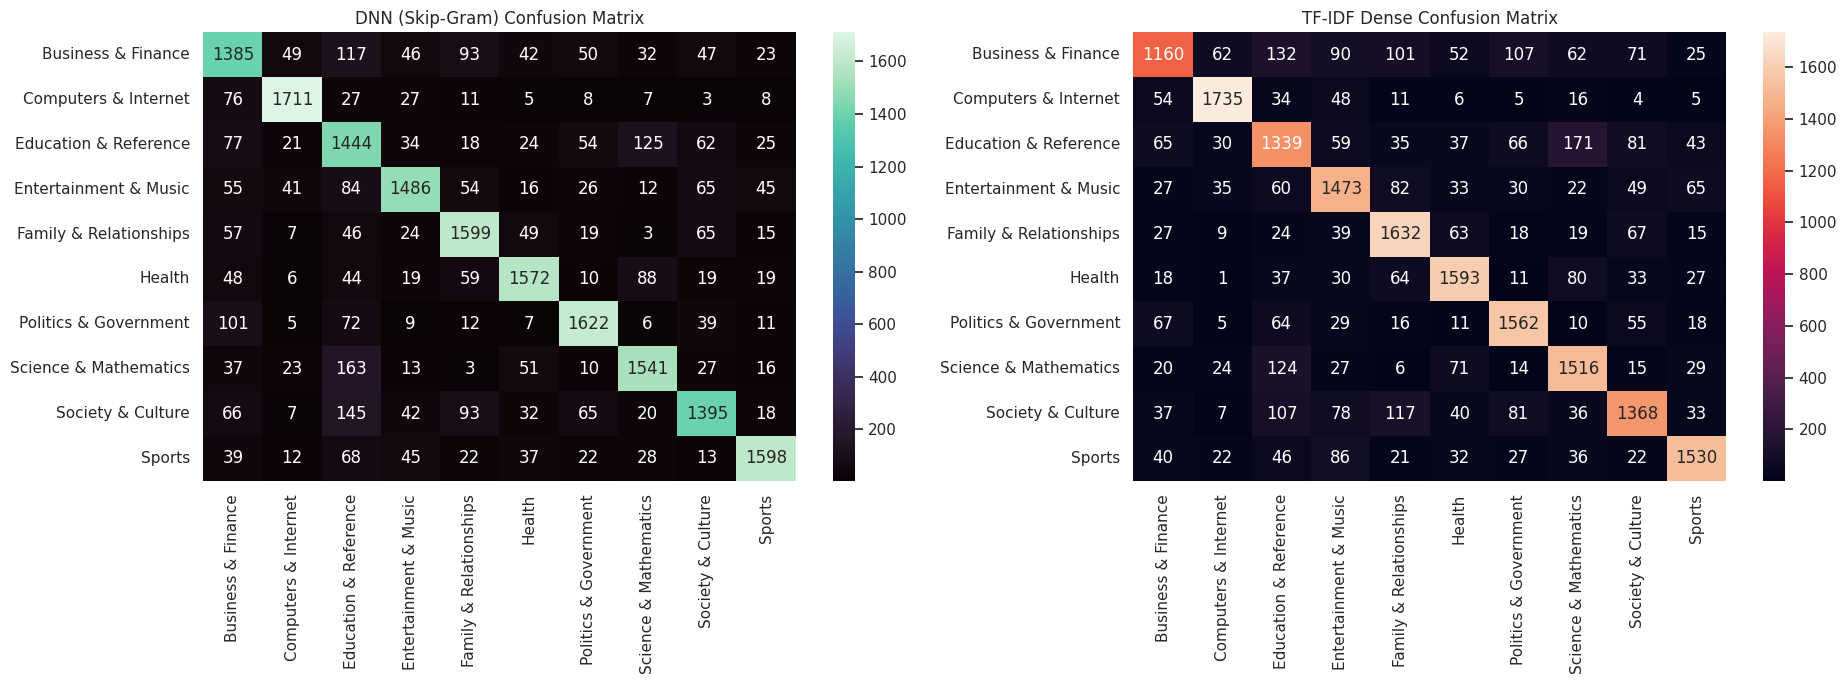

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(19, 7))
cm_dnn = confusion_matrix(y_true_dnn, y_pred_dnn)
sns.heatmap(cm_dnn, annot=True, fmt='d', ax=axes[0], cmap='mako',
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title('DNN (Skip-Gram) Confusion Matrix')
cm_tfidf = confusion_matrix(y_true_tfidf, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', ax=axes[1], cmap='rocket',
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title('TF-IDF Dense Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
def create_roc_auc_curve_multi_input(
    models,
    model_names,
    X_vals,
    y_vals,
    le):
    fig, axes = plt.subplots(1, len(models), figsize=(18, 6))
    for i, (model, name, X_val, y_val) in enumerate(
        zip(models, model_names, X_vals, y_vals)
    ):
        y_true = label_binarize(
            np.argmax(y_val, axis=1),
            classes=range(len(le.classes_))
        )[:, 0]
        y_score = model.predict(X_val)
        y_score = y_score[:, 0] if y_score.ndim > 1 else y_score
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        axes[i].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        axes[i].plot([0, 1], [0, 1], linestyle="--")
        axes[i].set_title(name)
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].legend(loc="lower right")
    plt.tight_layout()
    plt.show()

589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


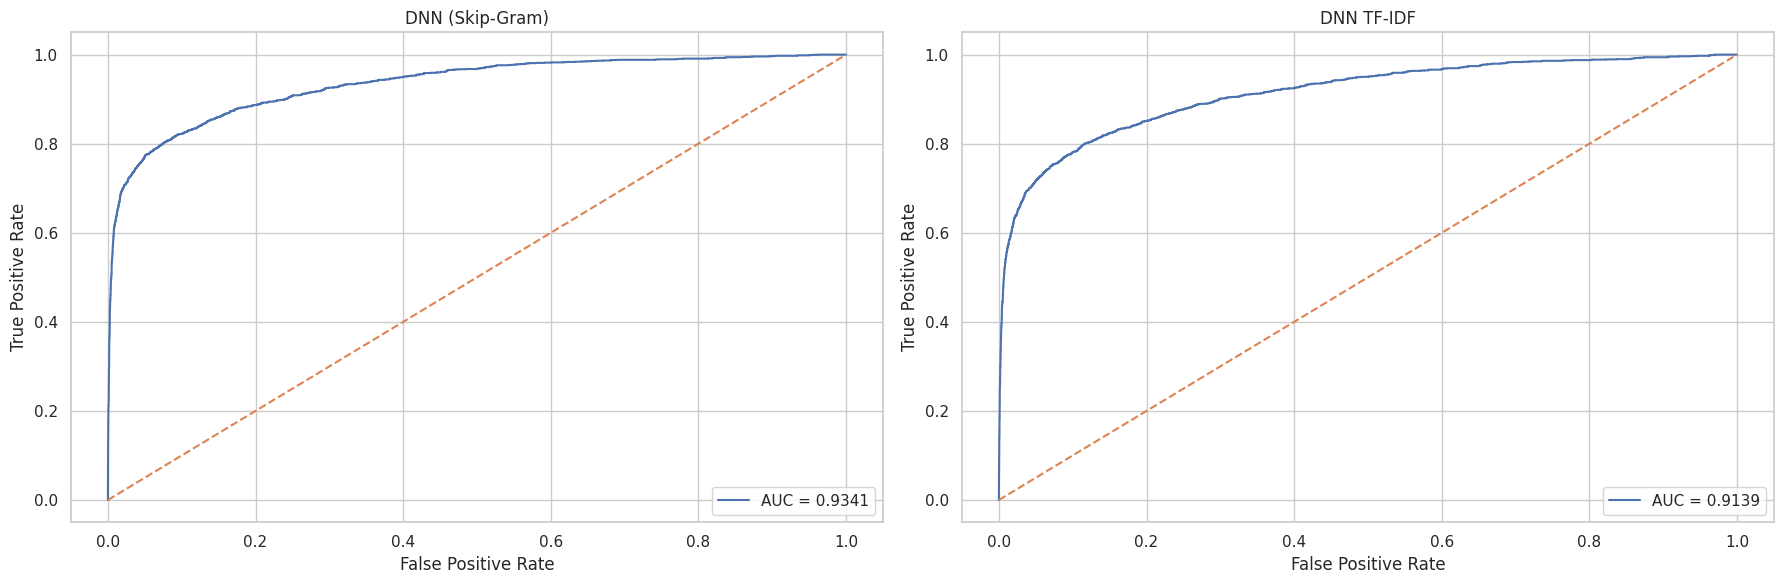

In [ ]:
create_roc_auc_curve_multi_input(
    models=[dnn_model, model],
    model_names=["DNN (Skip-Gram)", "DNN TF-IDF"],
    X_vals=[X_val, X_val_tfidf],
    y_vals=[y_val, y_val_tfidf],
    le=le
)

# **APPLY ON TEST DATASET**

In [ ]:
test_df = pd.read_csv("/kaggle/input/qanda-dataset/test.csv", engine="python", on_bad_lines="skip")
test_df["QA Text"] = test_df["QA Text"].fillna("missing")
test_df['QA Text'] = test_df['QA Text'].apply(nlp_clean)
test_sentences = test_df['QA Text'].apply(lambda x: simple_preprocess(str(x))).tolist()
def encode_sentence_safe(sentence):
    return [word_index[word] for word in sentence if word in word_index]
X_test_seq = pad_sequences(
    [encode_sentence_safe(s) for s in test_sentences],
    maxlen=MAX_LEN,
    padding="post"
)
y_pred_prob = dnn_model.predict(X_test_seq, batch_size=42)
y_pred_enc = np.argmax(y_pred_prob, axis=1)
test_df["Predicted_Class"] = le.inverse_transform(y_pred_enc)
from sklearn.metrics import classification_report, accuracy_score
if 'Class' in test_df.columns:
    test_df = test_df[test_df['Class'].notna()]
    y_true = le.transform(test_df["Class"])
    print("Accuracy:", accuracy_score(y_true, y_pred_enc[:len(y_true)]))
    print(classification_report(y_true, y_pred_enc[:len(y_true)], target_names=le.classes_))
test_df.to_csv("test_predictions.csv", index=False)
print("Predictions saved successfully to test_predictions.csv")

1429/1429 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Accuracy: 0.6046767446124102
                        precision    recall  f1-score   support

    Business & Finance       0.39      0.51      0.44      6000
  Computers & Internet       0.83      0.78      0.80      6000
 Education & Reference       0.37      0.50      0.42      6000
 Entertainment & Music       0.68      0.47      0.56      6000
Family & Relationships       0.61      0.67      0.64      5999
                Health       0.74      0.64      0.68      6000
 Politics & Government       0.72      0.62      0.67      6000
 Science & Mathematics       0.66      0.60      0.62      6000
     Society & Culture       0.49      0.45      0.47      6000
                Sports       0.79      0.82      0.80      6000

              accuracy                           0.60     59999
             macro avg       0.63      0.60      0.61     59999
          weighted avg       0.63      0.60      0.61     59999

Predictions saved successfull

In [ ]:
test_df

,QA Text,Class,Predicted_Class
0,question titlewhy zebras stripesquestion conte...,Science & Mathematics,Education & Reference
1,question titlewhat itsy bitsy sipder climb upq...,Education & Reference,Science & Mathematics
2,question titlewhat difference bachelors master...,Education & Reference,Education & Reference
3,question titlewhy women get pmsquestion conten...,Health,Science & Mathematics
4,question titleif coworker guilty unsanitary hy...,Health,Family & Relationships
...,...,...,...
59994,question titleif could fantasy figure would u ...,Family & Relationships,Computers & Internet
59995,question titletell something life people dont ...,Entertainment & Music,Society & Culture
59996,question titlewhy men always thinking sexquest...,Health,Business & Finance
59997,question titleest ce que domenech est un entra...,Sports,Sports
